## Data Cleaning and Investigation

In [51]:
import pandas as pd 
import numpy as np 
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
from string import punctuation
from nltk.stem import WordNetLemmatizer

In [52]:
data=pd.read_csv('Twitter_Data.csv')
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [61]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
lemmatizer = WordNetLemmatizer()
def remove_url(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)
def remove_hashtags(text):
    return   re.sub(r'#\w+', '', text)
def remove_special_characters_and_numbers(text):
    return  re.sub(r'[^\w\s]', '', text)
def remove_emojis(text):
    return emoji.demojize(text)
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)
def lower_case(text):
    return  text.lower()
def lower_case(text):
    return  text.translate(str.maketrans('', '', punctuation))
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in words]
    return  " ".join(lemmatized_tokens)
def remove_short_tweets(text,min_words=5):
    words = text.split()
    return text if len(words)>min_words else ''
def remove_white_spaces(text):
    return " ".join(text.split())
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""
def remove_stopwords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\benal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [62]:
def clean_data(text):
    text=remove_url(text)
    text=remove_mentions(text)
    text=remove_hashtags(text)
    text=remove_special_characters_and_numbers(text)
    text=remove_emojis(text)
    text=remove_mult_spaces(text)
    text=lower_case(text)
    text=lower_case(text)
    text=lemmatize(text)
    text=remove_short_tweets(text,min_words=5)
    text=remove_white_spaces(text)
    '''text=remove_stopwords(text)
    text=filter_non_english(text)'''
    return text 
data['clean_text'] = data['clean_text'].apply(clean_data)
data.head()

,clean_text,category
0,when modi promised minimum government maximum ...,1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp to...,2
3,asking his supporter prefix chowkidar their na...,2
4,answer who among these the most powerful world...,2


## Data Preprocessing:

In [53]:
data.drop_duplicates(subset='clean_text', keep='first', inplace=True)
duplicates_mask = data.duplicated(subset='clean_text', keep=False)
num_duplicates = duplicates_mask.sum()
num_duplicates 
 

0

In [54]:
data['category'].unique()

array([-1.,  0.,  1., nan])

In [55]:
data.dropna(subset=['category'], inplace=True)
data['category'].unique()

array([-1.,  0.,  1.])

In [56]:
missing_values_mask = data.isnull().sum()
missing_values_mask 


clean_text    1
category      0
dtype: int64

In [57]:
data.dropna(how='any', inplace=True)
missing_values_mask = data.isnull().sum()
missing_values_mask 

clean_text    0
category      0
dtype: int64

In [58]:
target_counts = data['category'].value_counts()
target_counts

category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64

In [59]:
data['category'] =data['category'].replace({0:'neutral',1:'positive',-1:'negative'})
data['category'] =data['category'].replace({'neutral':0,'positive':2,'negative':1})
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2


In [60]:
target_counts = data['category'].value_counts()
target_counts 

category
2    72249
0    55211
1    35509
Name: count, dtype: int64

## Text Vectorization:

In [63]:
# Import the required libraries
from nltk.tokenize import word_tokenize
 
from torch.nn.utils.rnn import pad_sequence
import torch

# Tokenize the text data into words for each tweet
tokenized_text = [word_tokenize(text) for text in data['clean_text']]

# Create a vocabulary set to store unique words from the tokenized text
vocab = set(word for tokens in tokenized_text for word in tokens)
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Create a dictionary to store the occurrence count of each word
word_occurrence = {}

# Count the occurrences of each word in the tokenized text
for tokens in tokenized_text:
    for word in tokens:
        if word in word_occurrence:
            word_occurrence[word] += 1
            if word_occurrence[word] > 10000:
                word_occurrence[word] = 10000
        else:
            word_occurrence[word] = 1

# Replace the words in tokenized text with their occurrence counts
tokenized_text_with_counts = [[word_occurrence[word] for word in tokens] for tokens in tokenized_text]


# Convert the tokenized text with word counts into torch tensors
tensor_sequences = [torch.tensor(sequence) for sequence in tokenized_text_with_counts]

# Pad the tensor sequences to create equal-length sequences for batch processing
padded_sequences = pad_sequence(tensor_sequences, batch_first=True)

 
 

Vocabulary Size: 101223


In [64]:
word_occurrence

{'when': 8028,
 'modi': 10000,
 'promised': 1410,
 'minimum': 590,
 'government': 6104,
 'maximum': 226,
 'governance': 525,
 'expected': 368,
 'him': 8304,
 'begin': 290,
 'the': 10000,
 'difficult': 346,
 'job': 4385,
 'reforming': 6,
 'state': 2789,
 'why': 10000,
 'doe': 2834,
 'take': 4968,
 'year': 9096,
 'get': 6458,
 'justice': 390,
 'should': 7139,
 'and': 10000,
 'not': 10000,
 'business': 935,
 'exit': 71,
 'psus': 44,
 'temple': 341,
 'talk': 1966,
 'all': 10000,
 'nonsense': 375,
 'continue': 594,
 'drama': 558,
 'will': 10000,
 'vote': 10000,
 'for': 10000,
 'what': 10000,
 'did': 6925,
 'just': 8114,
 'say': 9151,
 'welcome': 384,
 'bjp': 10000,
 'told': 891,
 'you': 10000,
 'rahul': 7211,
 'main': 1012,
 'campaigner': 149,
 'think': 4775,
 'relax': 72,
 'asking': 1210,
 'his': 10000,
 'supporter': 1629,
 'prefix': 59,
 'chowkidar': 4065,
 'their': 7984,
 'name': 2648,
 'great': 3332,
 'service': 417,
 'now': 10000,
 'there': 6662,
 'confusion': 68,
 'read': 1662,
 'crus

In [65]:
max_occurrence = max(word_occurrence.values())
print("Maximum Occurrence Count:", max_occurrence)


Maximum Occurrence Count: 10000


In [66]:
print(padded_sequences.shape)
X=padded_sequences
y=data['category'].values
print(X.shape)

torch.Size([162969, 52])
torch.Size([162969, 52])


In [67]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

 
# Train Word2Vec model on the tokenized_text data
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=200, window=5, min_count=1, workers=4)

# Create a dictionary to store word embeddings (word vectors) for each word in the vocabulary
word_embeddings = {word: model_w2v.wv[word] for word in model_w2v.wv.key_to_index}

# Create a list of word embeddings for all words in the vocabulary
word_vector_list = [word_embeddings[word] for word in model_w2v.wv.key_to_index]

# Convert the list of word embeddings into a numpy array
word_embeddings_np = np.stack(word_vector_list)

# Print the shape of the word embeddings numpy array
print("Shape of word embeddings array:", word_embeddings_np.shape)






Shape of word embeddings array: (101223, 200)


## Handling Imbalanced Data:

In [68]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X[:60000], y[:60000], test_size=0.2, random_state=42)
oversampler = RandomOverSampler()
X_train, y_train = oversampler.fit_resample(X_train, y_train)



In [69]:
# Import the required libraries
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert X_train and y_train to PyTorch tensors
train_data_tensor = torch.tensor(X_train)   
train_label_tensor = torch.tensor(y_train) 

# Convert the data and labels to float32 data type
train_data_tensor = train_data_tensor.to(torch.float32)
train_label_tensor = train_label_tensor.to(torch.float32) 

# Create a PyTorch TensorDataset using the training data and labels
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)

# Convert X_test and y_test to PyTorch tensors and set their data type to float32
test_data_tensor = torch.tensor(X_test).to(torch.float32) 
test_label_tensor = torch.tensor(y_test).to(torch.float32) 

# Create a PyTorch TensorDataset using the test data and labels
test_dataset = TensorDataset(test_data_tensor, test_label_tensor)

# Create a DataLoader for training data with batch_size=32 and shuffle the data during training
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, drop_last=True)

# Create a DataLoader for test data with batch_size=32 and shuffle the data during testing
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True, drop_last=True)

C:\Users\benal\AppData\Local\Temp\ipykernel_25728\348618231.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(X_test).to(torch.float32)


In [70]:
# Get the shape of the input data (features) from the training dataset
input_data_shape = train_dataset.tensors[0].shape

# Get the shape of the labels from the training dataset
label_shape = train_dataset.tensors[1].shape

# Print the shape of the input data (features)
print("Input data shape:", input_data_shape)

# Print the shape of the labels
print("Label shape:", label_shape)

# Get the data type of the input data (features) from the training dataset
input_data_type = train_dataset.tensors[0].dtype

# Get the data type of the labels from the training dataset
label_data_type = train_dataset.tensors[1].dtype

# Print the data type of the input data (features)
print("Input data type:", input_data_type)

# Print the data type of the labels
print("Label data type:", label_data_type)




Input data shape: torch.Size([63243, 52])
Label shape: torch.Size([63243])
Input data type: torch.float32
Label data type: torch.float32


## Model Building ,Training and Evaluation:

Stacking Lstms with attention layers

In [71]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim)
        hidden=(h0,c0)
        return hidden

In [262]:
# Define the number of classes for classification
input_size = 3

# Define the hidden dimension for the LSTM model
hidden_dim = 100

# Define the number of LSTM layers
lstm_layers = 2

# Specify whether the LSTM model is bidirectional or not
is_bidirectional = True

# Set the learning rate for the optimizer
lr= 4e-4

# Set the dropout rate for the LSTM model
dropout = 0.5

# Set the number of training epochs
epochs = 5
# Check if CUDA (GPU) is available, else use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the size of the vocabulary (number of unique words in the dataset)
VOCAB_SIZE = 101223

# Create an instance of the LSTM Sentiment Classifier model with specified hyperparameters
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, 200, hidden_dim, input_size, lstm_layers, dropout, is_bidirectional)

# Move the model to the specified device (CUDA/GPU or CPU)
model = model.to(device)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(word_embeddings_np))

# Allow the embedding matrix to be fine-tuned during training for better adaptation to the dataset
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function) for the model's training
criterion = nn.NLLLoss()

# Set up the optimizer for training the model's parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-6)

# Print the model summary
print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(93779, 200)
  (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [263]:
for e in range(10):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.long() 
        labels = labels.long()
        h = model.init_hidden(labels.size(0))
        print(inputs.shape)
        model.zero_grad()  
        output, h = model(inputs,h) 
        loss = criterion(output , labels)
        loss.backward()
        optimizer.step()

torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size([100, 43])
torch.Size

In [264]:
model.eval()
y_pred_list = []
y_test_list = []
    
with torch.no_grad():
    for inputs, labels in test_loader:
            inputs = inputs.long() 
            labels = labels.long()
            test_h = model.init_hidden(labels.size(0))
            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())


In [268]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_list, y_pred_list)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6938333333333333


AttributeError: 'numpy.ndarray' object has no attribute 'counts'

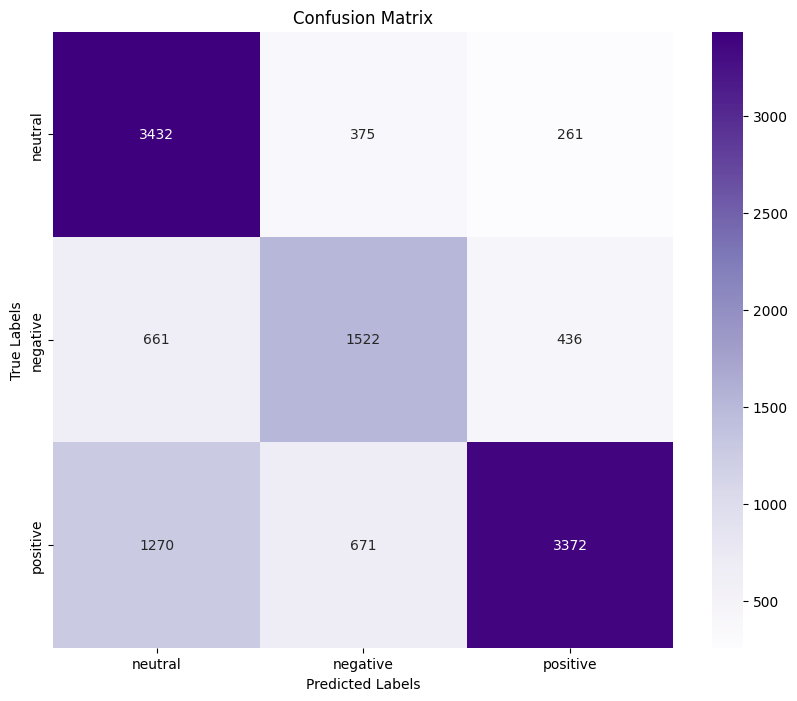

In [266]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
class_labels=['neutral','negative','positive']
cm = confusion_matrix(y_test_list, y_pred_list)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix1.pdf')
plt.show()

In [267]:
from sklearn.metrics import classification_report
print("Classification Report for Bidirectional LSTM:")
classification_report_lstm=classification_report(y_test_list, y_pred_list)
print(classification_report_lstm)
with open("classification_report_lstm1.txt", "w") as file:
    file.write("Classification Report for Bidirectional LSTM:\n")
    file.write(classification_report_lstm)

Classification Report for Bidirectional LSTM:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      4068
           1       0.59      0.58      0.59      2619
           2       0.83      0.63      0.72      5313

    accuracy                           0.69     12000
   macro avg       0.69      0.69      0.68     12000
weighted avg       0.71      0.69      0.69     12000



In [228]:
torch.save(model.state_dict(), "bidirectional_lstm_model1.pth")


Bert

In [24]:
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
# Load the pre-trained BERT tokenizer
all_input_ids = []
all_attention_masks = []

data_sentences = data['clean_text'].tolist()


# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Loop through all the text sequences in data_sentences
for text in data_sentences:
    # Tokenize and encode each text sequence
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=64,
        return_tensors='pt',
        return_attention_mask=True,
        truncation=True
    )
    # Get the input IDs and attention mask tensors for the current text sequence
    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']
    
    # Add the input IDs and attention masks to the lists
    all_input_ids.append(input_ids)
    all_attention_masks.append(attention_mask)

# Stack the input IDs and attention masks into tensors
input_ids_tensor = torch.cat(all_input_ids, dim=0)
attention_mask_tensor = torch.cat(all_attention_masks, dim=0)

# Print the shape of the tensors to verify
print("Input IDs Shape:", input_ids_tensor.shape)
print("Attention Mask Shape:", attention_mask_tensor.shape)

Input IDs Shape: torch.Size([162969, 64])
Attention Mask Shape: torch.Size([162969, 64])


In [72]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split



labels = torch.tensor(y[3000:7000], dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(input_ids_tensor[3000:7000], attention_mask_tensor[3000:7000], labels)

# Set the seed for reproducibility
torch.manual_seed(42)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set batch size for DataLoader
batch_size = 100

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the BERT model for sequence classification
num_labels = len(set(y))
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_ids, attention_mask, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accurcay: {accuracy:.4f}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.

KeyboardInterrupt: 

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_test_list = []
y_pred_list = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        
        y_test_list.extend(labels.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())
cm = confusion_matrix(y_test_list, y_pred_list)
print("Confusion Matrix:")
print(cm)


report = classification_report(y_test_list, y_pred_list)
print("Classification Report:")
print(report)
with open('classification_report_Bert1.txt', 'w') as file:
    file.write(report)




Confusion Matrix:
[[153  27  19]
 [ 22  94  10]
 [ 36  29 210]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       199
           1       0.63      0.75      0.68       126
           2       0.88      0.76      0.82       275

    accuracy                           0.76       600
   macro avg       0.74      0.76      0.75       600
weighted avg       0.77      0.76      0.77       600



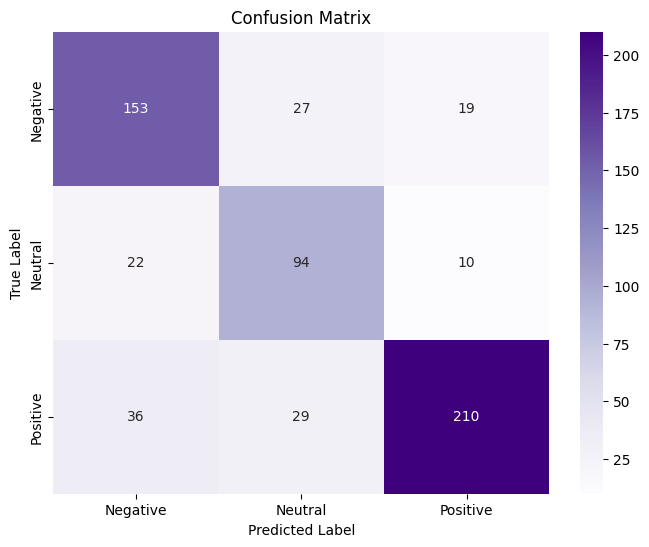

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

 
cm = confusion_matrix(y_test_list, y_pred_list)

 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion matrix BERT1.pdf')
plt.show()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a CSV file named 'data.csv' with 'text' and 'label' columns
data = pd.read_csv('Twitter_Data.csv')
data.dropna(how='any', inplace=True)
missing_values_mask = data.isnull().sum()
# Preprocess the text data (e.g., lowercasing, removing stopwords, etc.)
# For simplicity, we'll just lowercase the text in this example
data['clean_text'] = data['clean_text'].str.lower()

# Extract the features (text) and labels
X = data['clean_text'].values
y = data['category'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], test_size=0.2, random_state=42)

# Create the TfidfVectorizer to convert text data into numerical features
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create the SVM classifier
svm_model = SVC()

# Train the SVM model on the training data
svm_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test_vec)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.762
Precision: 0.7718551684796239
Recall: 0.762
F1-score: 0.754761206624323
